## Flood Vulnerability Index (FVI) Assessment 2

In [1]:
import os
import sys
from functools import reduce
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import geopandas as gpd
import rasterio
import fhv
# Mapping
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

# ADMINISTRATIVE SHAPEFILE
# ------------------------------------------------- #
# Upazila
shape3 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm3_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'] = f45t30.values
shape3['ADM3_PCODE'] = shape3['ADM3_PCODE'].astype(int)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape3['ADM2_PCODE'] = shape3['ADM2_PCODE'].astype(int)
shape3 = shape3.drop(shape3.columns[[0,1,4,5,6,9,10,11,12,13,14,15]], axis=1)
ADM2 = shape3[['ADM2_EN','ADM2_PCODE']].copy().drop_duplicates()
ADM2['ADM2_PCODE'] = ADM2['ADM2_PCODE'].astype(int)
# District
shape2 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm2_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
shape2 = shape2.drop(shape2.columns[[0,1,4,5,6,9,10,11,12,13]], axis=1)
f45t30 = '30' + shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape2['ADM2_PCODE'] = shape2['ADM2_PCODE'].astype(int)
# Division
shape1 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm1_bbs_20180410.shp')
# ------------------------------------------------- #

# District-level Population
df = pd.read_excel('./data/disaster_records/damagedata_DDM.xlsx', 
                   sheet_name='total_population',skiprows=0,skipfooter=0).fillna(0)
popu2017 = df[['ADM2_PCODE', 'Population']]

# Load Vulnerability
vuln = pd.read_hdf('./data/vuln_calculated_adm3.hdf')

## Join 2017 FFWC Flood Forecast and Inundation to Population data

In [2]:
# Union ID list (5160)
uidList = pd.read_hdf('./data/uidlist.hdf')
# Flatten cell indices for Union ID
uidx = np.load('./data/uidx.npz', allow_pickle=True)['uidx']
# Shapefiles of administrative units
shp_district = gpd.read_file('./data/adm_district.shp')
shp_upazila = gpd.read_file('./data/adm_upazila.shp')
shp_union = gpd.read_file('./data/adm_union.shp')

# Load data
inun = rasterio.open('./data/bgd_inun_30m.tif').read(1).flatten()                # 1 (Perennial waterbodies), 2 (Flood inundation area)
popu = rasterio.open('./data/bgd_ppp_2017_30m_decuple.tif').read(1).flatten()    # Population Per Pixel (Decuple value)
# popu = (popu/popu.sum()*popu2017['Population'].sum()*10).astype(np.int16)        # Calibration
fcst = rasterio.open('./data/flood2017forecast_30m_aug16_ffwc_decuple.tif').read(1).flatten()  # Flood depth (decuple; unit is 10 cm)

In [7]:
# Affected population by Flood Inundation and Flood Forecast
# (a) Flood Inundation      # 1 (Perennial waterbodies), 2 (Flood inundation area)
# *Remove population not in both perennial water and flood inundation
popuInun = popu.copy()
popuInun[~np.isin(inun,[2])] = 0   
# (b) Flood Forecast        # Flood depth (decuple; unit is 10 cm)
# *Affected population increase linearly with flood depth by 3m
popuFcst = popu.copy(); thsd = 35                          
popuFcst[fcst <= thsd] =  popuFcst[fcst <= thsd]*(fcst[fcst <= thsd])**2/thsd**2
popuFcst[fcst < 10] = 0

# Counting population
totlPopu = np.zeros(uidList.shape)
afftPopuInun = np.zeros_like(totlPopu)
afftPopuFcst = np.zeros_like(totlPopu)
totlCell = [len(udx) for udx in uidx]
afftCellInun = np.zeros_like(totlPopu)
afftCellFcst = np.zeros_like(totlPopu)
for i, uid in uidList.iteritems():
    totlPopu[i] = popu[uidx[i]].sum()
    afftPopuInun[i] = popuInun[uidx[i]].sum()
    afftPopuFcst[i] = popuFcst[uidx[i]].sum()
    afftCellInun[i] = np.isin(inun[uidx[i]], [1,2]).sum()
    afftCellFcst[i] = np.isin(fcst[uidx[i]], [1]).sum()

# Rescale from decuple to normal and Add one to avoid numeric errors
totlPopu = (totlPopu+1)/10
afftPopuInun /= 10
afftPopuFcst /= 10

# Generate a Union dataframe
impact4 = shp_union.drop('geometry', axis=1)
impact4['POP'], impact4['POPINUN'], impact4['POPFCST'] = totlPopu, afftPopuInun, afftPopuFcst
impact4['POPINUNR'] = afftPopuInun/totlPopu
impact4['POPFCSTR'] = afftPopuFcst/totlPopu
impact4['CELL'], impact4['CELLINUN'], impact4['CELLFCST'] = totlCell, afftCellInun, afftCellFcst
impact4['CELLINUNR'] = afftCellInun/totlCell
impact4['CELLFCSTR'] = afftCellFcst/totlCell
# Aggregate to Upazila level
varlist = ['POP','POPINUN','POPFCST','CELL','CELLINUN','CELLFCST']
impact3 = impact4.groupby(['ADM3_PCODE', 'ADM3_EN'])[varlist].sum()
impact3['POPINUNR'] = impact3['POPINUN']/impact3['POP']
impact3['POPFCSTR'] = impact3['POPFCST']/impact3['POP']
impact3['CELLINUNR'] = impact3['CELLINUN']/impact3['CELL']
impact3['CELLFCSTR'] = impact3['CELLFCST']/impact3['CELL']
impact3['ADM2_PCODE'], impact3['ADM2_EN'] = shp_upazila['ADM2_PCODE'].values, shp_upazila['ADM2_EN'].values

# Print
print('POPINUN: {:,}'.format(impact3['POPINUN'].sum().astype(int)))
print('POPFCST: {:,}'.format(impact3['POPFCST'].sum().astype(int)))

POPINUN: 19,642,620
POPFCST: 19,812,664


## District-level averaged domain vulnerability, FHV, and affected population

In [9]:
# Affected popoulation in Upazila 
impact = impact3.reset_index().drop(['ADM2_PCODE','ADM2_EN','ADM3_EN'], axis=1)
impact['ADM3_PCODE'] = impact['ADM3_PCODE'].astype(int)
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
targ = (impact['ADM3_PCODE']/10000).astype(int) == 45
f45t30 = 300000 + impact.loc[targ, 'ADM3_PCODE'] % 10000
impact.loc[targ, 'ADM3_PCODE'] = f45t30.values
impact['ADM2_PCODE'] = (impact['ADM3_PCODE'] / 100).astype(int)
impact = impact.set_index('ADM3_PCODE')

# Merge vulnerability
merge3 = pd.merge(impact, vuln, how='outer', left_index=True, right_index=True)

# IMPACT ASSESSMENT -------------------------- #
# Multiplication (will be divided by district population)
# - Total population
merge3['EQUAL'] = merge3['POP']*merge3['equal']
merge3['EQUAL1'] = merge3['POP']*merge3['equal1']
merge3['EQUAL2'] = merge3['POP']*merge3['equal2']
merge3['EQUAL3'] = merge3['POP']*merge3['equal3']
merge3['EQUALF'] = merge3['POPFCST']*merge3['equal']
merge3['EQUAL1F'] = merge3['POPFCST']*merge3['equal1']
merge3['EQUAL2F'] = merge3['POPFCST']*merge3['equal2']
merge3['EQUAL3F'] = merge3['POPFCST']*merge3['equal3']
merge3['PCA'] = merge3['POP']*merge3['pca']
merge3['PCA1'] = merge3['POP']*merge3['pca1']
merge3['PCA2'] = merge3['POP']*merge3['pca2']
merge3['PCA3'] = merge3['POP']*merge3['pca3']
# - Affected population (predictive)
merge3['EQUALFCST'] = merge3['POPFCST']*merge3['equal']
merge3['EQUALINUN'] = merge3['POPINUN']*merge3['equal']
merge3['PCAFCST'] = merge3['POPFCST']*merge3['pca']
merge3['PCAINUN'] = merge3['POPINUN']*merge3['pca']
# District-level aggregation
cols = ['POPINUN','POPFCST',
        'EQUAL','EQUAL1','EQUAL2','EQUAL3','EQUALFCST','EQUALINUN',
        'EQUALF','EQUAL1F','EQUAL2F','EQUAL3F',
        'PCA','PCA1','PCA2','PCA3','PCAFCST','PCAINUN']
merge2 = merge3.groupby('ADM2_PCODE')[cols].sum().reset_index()
# - Import population
merge2 = pd.merge(popu2017, merge2, how='outer',on='ADM2_PCODE')
merge2 = merge2.rename(columns={'Population':'POP'}).set_index('ADM2_PCODE')
# - Calculation
merge2['EQUAL'] = merge2['EQUAL']/merge2['POP']
merge2['EQUAL1'] = merge2['EQUAL1']/merge2['POP']
merge2['EQUAL2'] = merge2['EQUAL2']/merge2['POP']
merge2['EQUAL3'] = merge2['EQUAL3']/merge2['POP']
merge2['EQUALF'] = merge2['EQUALF']/(merge2['POPFCST']+1)
merge2['EQUAL1F'] = merge2['EQUAL1F']/(merge2['POPFCST']+1)
merge2['EQUAL2F'] = merge2['EQUAL2F']/(merge2['POPFCST']+1)
merge2['EQUAL3F'] = merge2['EQUAL3F']/(merge2['POPFCST']+1)
merge2['PCA'] = merge2['PCA']/merge2['POP']
merge2['PCA1'] = merge2['PCA1']/merge2['POP']
merge2['PCA2'] = merge2['PCA2']/merge2['POP']
merge2['PCA3'] = merge2['PCA3']/merge2['POP']
merge2['POPINUNR'] = merge2['POPINUN']/merge2['POP']
merge2['POPFCSTR'] = merge2['POPFCST']/merge2['POP']
merge2['POPINUNM'] = merge2['POPINUN']/10**6
merge2['POPFCSTM'] = merge2['POPFCST']/10**6
merge2['EQUALFCST'] = merge2['EQUALFCST']/(merge2['POPFCST']+1)
merge2['EQUALINUN'] = merge2['EQUALINUN']/(merge2['POPINUN']+1)
merge2['PCAFCST'] = merge2['PCAFCST']/(merge2['POPFCST']+1)
merge2['PCAINUN'] = merge2['PCAINUN']/(merge2['POPINUN']+1)
# -------------------------------------------- #

# GeoDataFrame
merge3 = merge3.drop('ADM2_PCODE', axis=1)
mapdata3 = shape3.merge(merge3, how='outer', on='ADM3_PCODE')
mapdata2 = shape2.merge(merge2, how='outer', on='ADM2_PCODE')

### Load 2017 flood damage records

In [11]:
# Load damage DataFrame
cols_drop = ['NDISPPOPU','DAMGROAD','NTRAUMA']
damage = pd.read_hdf('./data/impact.hdf',key='data').drop(cols_drop, axis=1)
damage_table = pd.read_hdf('./data/impact_table.hdf', key='table')
damage_table = damage_table.drop(index=damage_table[damage_table.Name.isin(cols_drop)].index, axis=0)
# Rescale using MinMax scaler (Do not scale 'PAFFCPOPU')
damage[damage.columns[1:]] = MinMaxScaler().fit_transform(damage[damage.columns[1:]])

# Merge Affected population and FHV with damage
cols = ['POP','POPFCST','POPINUN','POPFCSTR','POPINUNR','POPFCSTM','POPINUNM',
        'EQUAL','EQUAL1','EQUAL2','EQUAL3','EQUALFCST','EQUALINUN',
        'EQUALF','EQUAL1F','EQUAL2F','EQUAL3F',
        'PCA','PCA1','PCA2','PCA3','PCAFCST','PCAINUN']
result = pd.merge(merge2[cols], damage, how='inner', left_index=True, right_index=True).reset_index()
result = result.merge(shape2[['ADM2_EN','ADM2_PCODE','ADM1_EN','ADM1_PCODE']], how='inner', left_on='ADM2_PCODE',right_on='ADM2_PCODE')
result = result.set_index('ADM2_EN').reset_index()
# - Number of the reported affected population
result['POPREPO'] = result['PAFFCPOPU']*result['POP']
result['POPREPOM'] = result['POPREPO']/10**6

# Distress, Damage, Disruption, and Health
result['Distress'] = MinMaxScaler().fit_transform(result[['PAFFCPOPU','NDEATH']]).mean(1)
result['Damage'] = MinMaxScaler().fit_transform(result[['NDAMGHOUS','DAMGCLAND']]).mean(1)
result['Disruption'] = MinMaxScaler().fit_transform(result[['NAFFCINST','NDAMGTUBE']]).mean(1)
result['Health'] = MinMaxScaler().fit_transform(result[['NDIARRHEA','NODIEASE']]).mean(1)


# Reorder districts according to the division
result = result.sort_values('ADM1_PCODE')

### Barchart of FHV and damage

In [60]:
temp

,ADM1_PCODE,ADM2_EN,Forecast,Satellite,Reported,Distress,Damage,Disruption,Health
0,10,Barguna,0.071080,0.010785,0.000000,0.000000,0.000000,0.000000,-0.878230
1,20,Brahamanbaria,1.522488,0.820398,0.003778,0.001388,0.005168,0.003517,-0.878230
2,20,Chandpur,0.562719,0.118126,0.005667,0.002661,0.007177,0.024032,-0.848374
3,20,Comilla,1.123815,0.453140,0.137882,0.060517,0.014264,0.000000,-0.642868
4,20,Rangamati,0.000000,0.011491,0.032000,0.058916,0.024351,0.000000,-0.878230
5,30,Dhaka,1.713593,0.292560,0.046419,0.003680,0.048561,0.084408,0.554337
6,30,Faridpur,0.312610,0.308116,0.052200,0.030076,0.009271,0.027550,-0.143989
7,30,Madaripur,0.231480,0.065885,0.029260,0.028211,0.001494,0.000197,-0.221048
8,30,Manikganj,0.250139,0.457006,0.184911,0.178733,0.281135,0.358805,0.941070
9,30,Munshiganj,0.626327,0.042590,0.034989,0.026490,0.019352,0.002931,-0.878230


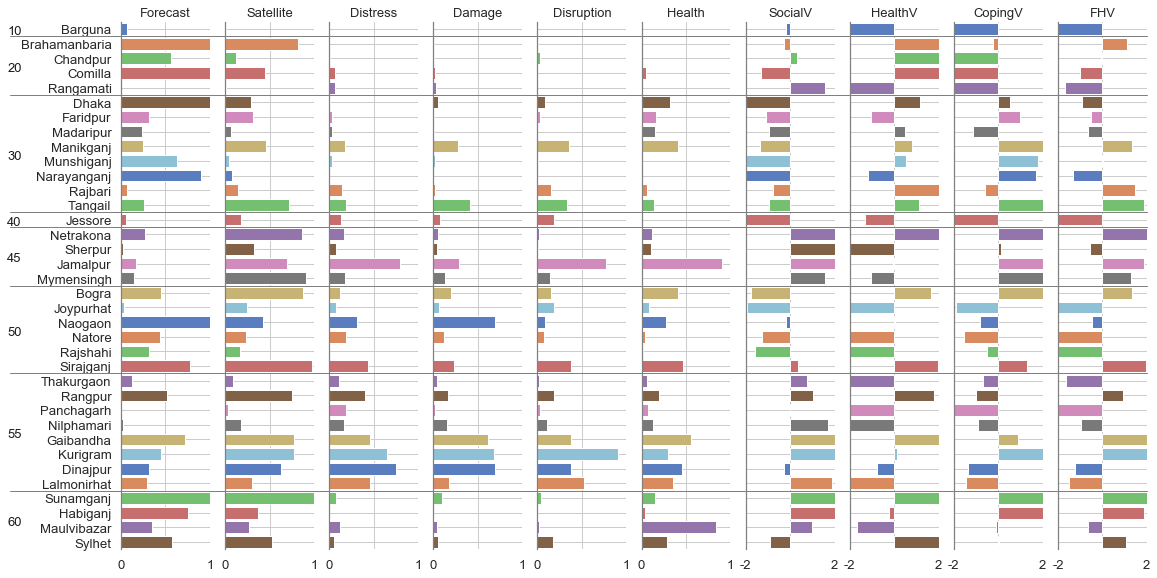

./figures/chart_impact.png is saved.


In [99]:
# Temporary dataframe
temp = result[['ADM1_PCODE','ADM2_EN',
               'POPFCSTM','POPINUNM', #'POPREPOM',
#                'NDEATH', 'NDAMGHOUS', 'DAMGCLAND',
#                'NAFFCINST','NDAMGTUBE',
#                'NDIARRHEA', 'NODIEASE',
               'Distress','Damage','Disruption','Health',
               'EQUAL1','EQUAL2','EQUAL3','EQUAL',
#                'EQUAL1F','EQUAL2F','EQUAL3F','EQUALF',
#                'PCA1','PCA2','PCA3','PCA'
              ]]
temp = temp.rename(columns={'POPFCSTM':'Forecast','POPINUNM':'Satellite','POPREPOM':'Reported',
                            'NDEATH':'Death','NDAMGHOUS':'Houses','DAMGCLAND':'Land',
                            'NAFFCINST':'Institutions','NDAMGTUBE':'Tubewell',
                            'NDIARRHEA':'Diarrhea','NODIEASE':'Diseases',
                            'EQUAL1':'SocialV','EQUAL2':'HealthV','EQUAL3':'CopingV','EQUAL':'FHV',
                            'EQUAL1F':'eSocialF','EQUAL2F':'eHealthF','EQUAL3F':'eCopingF','EQUALF':'EQUALF',
#                             'PCA1':'pSocial','PCA2':'pHealth','PCA3':'pCoping','PCA':'PCA'
                             })
cols_div = ['EQUAL','eSocial','eHealth','eCoping',
            'EQUALF','eSocialF','eHealthF','eCopingF',
            'PCA','pSocial','pHealth','pCoping',
            'SocialV','HealthV','CopingV','FHV']

# Standardization
temp[temp.columns[temp.columns.isin(cols_div)]] = StandardScaler().fit_transform(temp[temp.columns[temp.columns.isin(cols_div)]])

# PairGrid plots
sns.set(style="white", font_scale=1.2)
g = sns.PairGrid(temp, x_vars=temp.columns[2:], y_vars=['ADM2_EN'], height=8, aspect=.20)
g.map(sns.barplot, palette='muted')

# Title, axis, and grids
g.set(xlabel='',ylabel='', yticklabels=temp['ADM2_EN'])
for ax, title in zip(g.axes.flat, temp.columns[2:]):
    # Title (Group name)
    ax.set_title(title, fontfamily='sans-serif', fontsize=13)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.spines['left'].set_color('grey')
    if ~np.isin(title, cols_div):
        ax.set_xlim(0,1)
        ax.set_xticks([0,0.5,1])
        ax.set_xticklabels([0, '', 1])
    else:
        ax.set_xlim(-1,1)
        ax.set_xticks([-1,0,1])
        ax.set_xticklabels(['-2', '', '2'])

# Division lines and names
divs = temp['ADM1_PCODE'].tolist()
for i, div in enumerate(divs):
    if i and div != divs[i - 1]:
        # Division line
        g.axes.flat[-1].axhline(i-0.5, xmin=-len(temp.columns[2:])-1.8, 
                                xmax=1, c='#808080FF', lw=1, clip_on=False)
    if div != divs[i - 1]:
        # Division name
        lx = np.arange(len(temp['ADM1_PCODE']))[np.isin(divs, div)]
        g.axes.flat[0].annotate(div, [-1.2, np.median(lx)+0.15], 
                    annotation_clip=False, xycoords='data',
                    color='k', ha='center', va='center',fontfamily='sans-serif', fontsize=13)    
    
    
# Remove axis lines
sns.despine(left=False, bottom=True);plt.tight_layout(pad=0.4);plt.show()

# Save a figure
if True:
    fn_save = './figures/chart_impact.png'
    g.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

### Table of correlation between FHV and domain vulnerability and post-disaster layers

In [110]:
# Temporary dataframe
temp = result[['Distress','Damage','Disruption','Health',
               'EQUAL','EQUAL1','EQUAL2','EQUAL3',
#                'EQUALF','EQUAL1F','EQUAL2F','EQUAL3F',
               'PCA','PCA1','PCA2','PCA3'
              ]]
# Calculate correlation
corrmat = temp[temp.columns].corr(method=lambda x, y: pearsonr(x, y)[0]) - np.eye(len(temp.columns))
pvalmat = temp[temp.columns].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(temp.columns))
corrval = corrmat.round(2).copy()
# Add significance symbols
corrval[pvalmat <= 0.1] = corrval[pvalmat <= 0.1].applymap(lambda x: '{}*'.format(x))
corrval[pvalmat <= 0.05] = corrval[pvalmat <= 0.05].applymap(lambda x: '{}**'.format(x))
corrval[pvalmat <= 0.01] = corrval[pvalmat <= 0.01].applymap(lambda x: '{}***'.format(x))
# Change column name
table = corrval.loc[['Distress','Damage','Disruption','Health'],
                    ['EQUAL','EQUAL1','EQUAL2','EQUAL3',
#                      'EQUALF','EQUAL1F','EQUAL2F','EQUAL3F', 
                     'PCA','PCA1','PCA2','PCA3'
                    ]].T
table.index = ['FHV','Socio-econ','Health','Coping capacity','FHV','Socio-econ','Health','Coping capacity']
# damage_table[['Domain','Description']].set_index('Domain')
table

,Distress,Damage,Disruption,Health
FHV,0.27,0.31*,0.33***,0.31*
Socio-econ,0.42***,0.27,0.3*,0.23
Health,0.05,0.13,0.08,0.13
Coping capacity,0.18,0.26,0.33***,0.29*
FHV,-0.05,-0.03,0.04,0.08
Socio-econ,-0.16,-0.25,-0.19,-0.04
Health,-0.01,0.08,0.03,0.02
Coping capacity,0.05,0.06,0.19,0.17


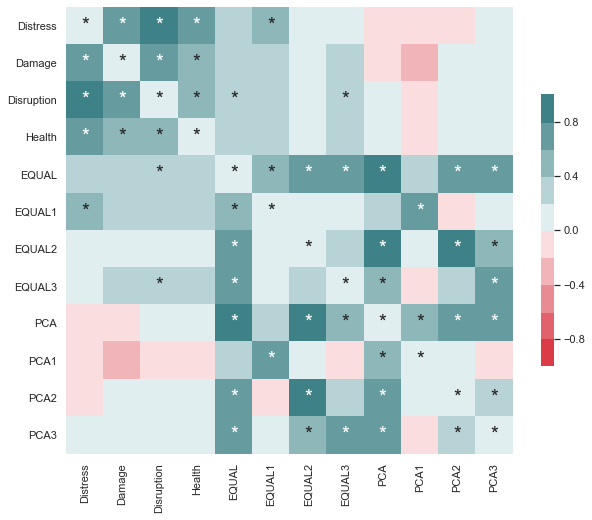

In [120]:
# Plotting

pvalsym = np.full(corrmat.shape, '')
pvalsym[pvalmat <= 0.05] = '*'


sns.set(style="white", font_scale=1)
cmap=sns.diverging_palette(10, 200, n=10)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corrmat, ax=ax, vmin=-1, vmax=1, center=0,
                 annot=pvalsym, fmt='', annot_kws={"size": 20},
                 cmap=cmap, square=True,
                 cbar_kws={'orientation': 'vertical', 'shrink':.5})

### Barchart of the number of affected population (Forecast, Satellite, and Reported)

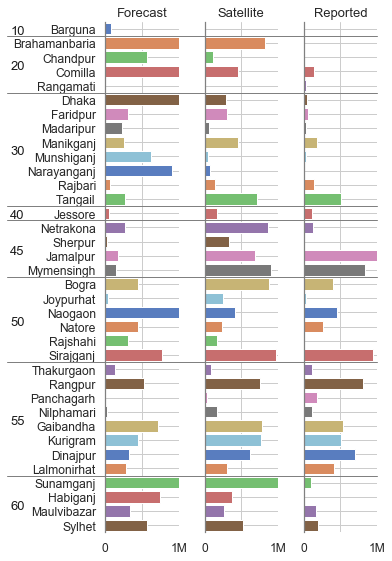

In [13]:
# Temporary dataframe
temp = result[['ADM1_PCODE','ADM2_EN','POPFCSTM','POPINUNM','POPREPOM']]
temp = temp.rename(columns={'POPFCSTM':'Forecast','POPINUNM':'Satellite','POPREPOM':'Reported'})

# Plotting setting
sns.set(style="white", font_scale=1.1)
g = sns.PairGrid(temp, x_vars=temp.columns[2:], y_vars=['ADM2_EN'], height=8, aspect=.25)
g.map(sns.barplot, palette='muted')
g.set(xlim=[0, 1], xticks=[0,0.5,1], xticklabels=[0, '', '1M'], xlabel='', 
      ylabel='', yticklabels=temp['ADM2_EN'])
# Column name and Grids
for ax, title in zip(g.axes.flat, temp.columns[2:]):
    # Title (Group name)
    ax.set_title(title, fontfamily='sans-serif', fontsize=13)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.spines['left'].set_color('grey')

# Division lines and names
divs = temp['ADM1_PCODE'].tolist()
for i, div in enumerate(divs):
    if i and div != divs[i - 1]:
        # Division line
        g.axes.flat[-1].axhline(i-0.5, xmin=-4.05, xmax=1, c='#808080FF', lw=1, clip_on=False)
    if div != divs[i - 1]:
        # Division name
        lx = np.arange(len(temp['ADM1_PCODE']))[np.isin(divs, div)]
        g.axes.flat[0].annotate(div, [-1.2, np.median(lx)+0.15], 
                    annotation_clip=False, xycoords='data',
                    color='k', ha='center', va='center',fontfamily='sans-serif', fontsize=13)
            
# Remove axis lines
sns.despine(left=False, bottom=True);plt.tight_layout();plt.show()

# Save a figure
if False:
    fn_save = './figures/affected_popu_chart.png'
    g.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

## Mapping the results

### (a1) Percentage of affected population (Forecast and Inundation)

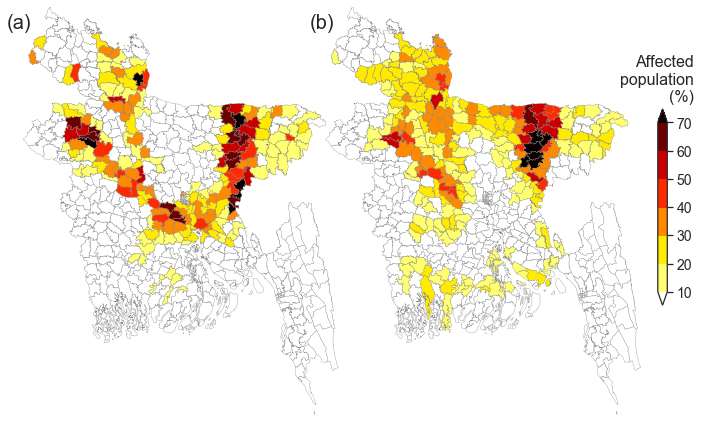

./figures/affected_popu_upazila.png is saved.


In [43]:
# Colormap
bounds = list(np.arange(0.1,0.71,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'hot_r', labloc='on',boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)']
figlabel = 'Affected\npopulation\n(%)'
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,5), facecolor='w')
for (i, el) in enumerate(['POPFCSTR','POPINUNR']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    mapdata3.plot(ax=ax, column=el,cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, 
                  linewidth=0.3, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.01, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)    
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="5%", height="40%",
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0.27, 0.6, 1.2),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='vertical')
cbar.ax.set_yticklabels(['%.f'%lb for lb in np.array(bounds)*100], 
                        fontname='arial', fontsize=14)
cbar.ax.annotate(figlabel, xy=(3.8, 1.15), xycoords='axes fraction',
                horizontalalignment='right', verticalalignment='center',
                fontname='arial',fontsize=16)    
plt.show()

# Save a figure
if True:
    fn_save = './figures/affected_popu_upazila.png'
    fig.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

### (a2) Percentage of affected population (Forecast, Inundation, and Reported)

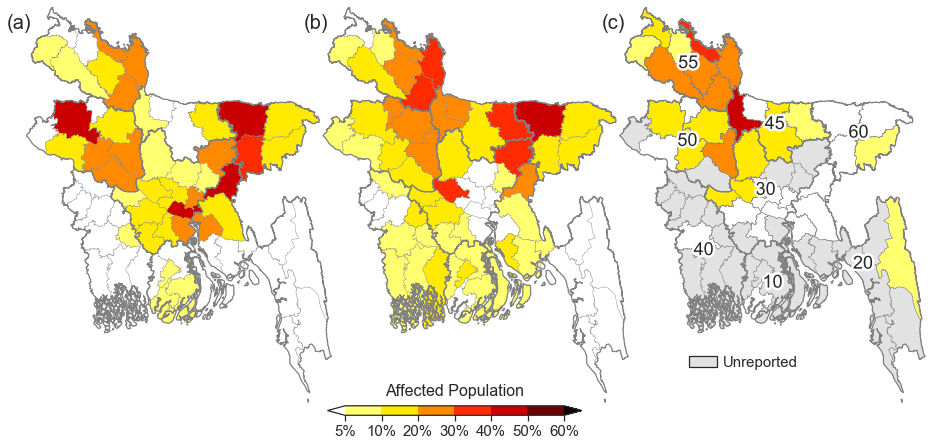

./figures/affected_popu_district.png is saved.


In [563]:
# Import reported percentage of affected population
afftpopu = pd.read_hdf('./data/impact.hdf',key='data').reset_index()[['ADM2_PCODE','PAFFCPOPU']]
mapdata = mapdata2.merge(afftpopu,how='outer',left_on='ADM2_PCODE',right_on='ADM2_PCODE').fillna(0)
unreported = mapdata[~np.isin(mapdata['ADM2_PCODE'], result['ADM2_PCODE'])]

# Colormap
bounds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'hot_r', labloc='on',boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)', '(c)']
figlabel = 'Affected Population'
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,5), facecolor='w')
for (i, el) in enumerate(['POPFCSTR','POPINUNR','PAFFCPOPU']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    mapdata.plot(ax=ax, column=el, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.3, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.02, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)
    if i == 2:
        # Unreported districts
        unreported.boundary.plot(ax=ax, facecolor='#E2E2E2',edgecolor='None')
        mapdata.boundary.plot(ax=ax, facecolor='None', linewidth=0.3, edgecolor='grey')
        # Labels of ADM1_PCODE
        shape1.apply(lambda x: ax.annotate(s=x.ADM1_PCODE, xy=x.geometry.centroid.coords[0], 
                                           ha='center',va='center',fontsize=18, fontname='arial',
                                           path_effects=[pe.withStroke(linewidth=5, foreground="white")]),axis=1)
    shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='grey')     
plt.tight_layout(pad=-2)

# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(-0.95, -0.03, 1.8, 0.8),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.f%%'%lb for lb in np.array(bounds)*100], 
                        fontname='arial', fontsize=15)
cbar.set_label(figlabel, labelpad=-55, 
               fontname='arial', fontsize=16, 
               horizontalalignment='center')

# Colorbar for the unreported districts
cax2 = inset_axes(ax, width="46%", height="3.5%", bbox_to_anchor=(0.12, -0.68, 0.2, 0.8),bbox_transform=ax.transAxes,borderpad=0)
cbar2 = mpl.colorbar.ColorbarBase(cax2, cmap=ListedColormap('#E2E2E2'),ticks=[], orientation='horizontal')
cbar2.ax.text(1.2,0,'Unreported',fontname='arial', fontsize=15)
plt.show()

# Save a figure
if False:
    fn_save = './figures/affected_popu_district.png'
    fig.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

### District-level Average FHV of Affected Population

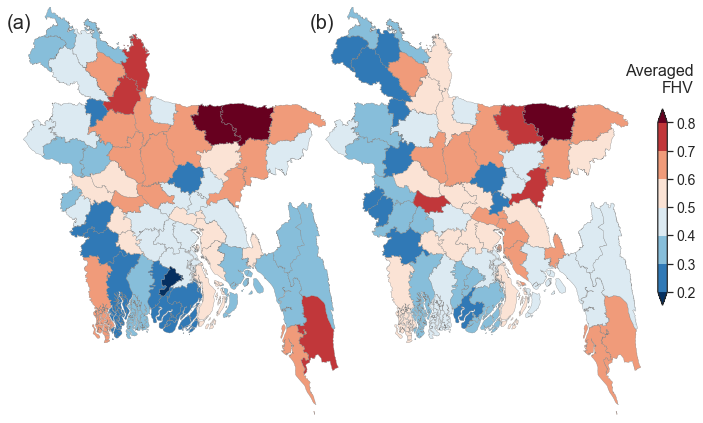

./figures/avg_fhv_district.png is saved.


In [97]:
# Colormap
bounds = list(np.arange(0.2,0.8,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'RdBu_r', labloc='on',boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)']
figlabel = 'Averaged\nFHV'
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,5), facecolor='w')
for (i, el) in enumerate(['EQUAL','PCA']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    mapdata2.plot(ax=ax, column=el,cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, 
                     linewidth=0.3, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.01, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)    
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="5%", height="40%",
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0.27, 0.6, 1.2),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='vertical')
cbar.ax.set_yticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=14)
cbar.ax.annotate(figlabel, xy=(3.8, 1.15), xycoords='axes fraction',
                horizontalalignment='right', verticalalignment='center',
                fontname='arial',fontsize=16)    
plt.show()

# Save a figure
if True:
    fn_save = './figures/avg_fhv_district.png'
    fig.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

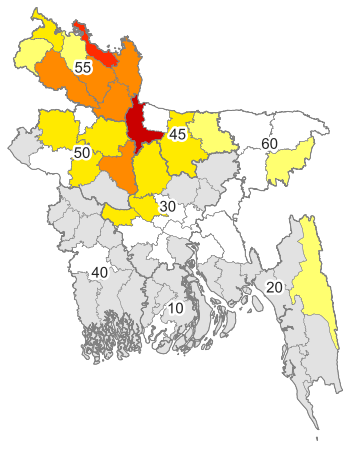

In [547]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,8), facecolor='w')
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
mapdata.plot(ax=ax, column='PAFFCPOPU', cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.3, edgecolor='grey')


unreported.boundary.plot(ax=ax, facecolor='#E2E2E2',edgecolor='None')
mapdata.boundary.plot(ax=ax, facecolor='None', linewidth=0.3, edgecolor='grey')
shape1.boundary.plot(ax=ax, linewidth=1, edgecolor='grey')        
shape1.apply(lambda x: ax.annotate(s=x.ADM1_PCODE, xy=x.geometry.centroid.coords[0], 
                                   ha='center',va='center',fontsize=15, fontname='arial',
                                   path_effects=[pe.withStroke(linewidth=5, foreground="white")]),axis=1)

plt.show()